In [59]:
import cv2 
import numpy as np
import glob
import os
from itertools import combinations 
from itertools import product
import random
import matplotlib.pyplot as plt
from random import randrange

In [104]:
import tensorflow as tf
import keras 
from keras.layers import Dense, MaxPooling2D, Convolution2D, Dropout, Input, Flatten, Subtract, merge,Conv2D,Conv2DTranspose,Lambda,concatenate,GlobalMaxPooling2D,Activation
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.models import Model,Sequential
#from keras.initializers.h as 
from keras.models import load_model
from keras.regularizers import l2 
from pandas import read_excel

#pip install xlrd

In [61]:
path_input_images =  '/tensorflow/IITD_Database/'

In [62]:
mask_path  = '/tensorflow/iit_unet/mask_data/'

In [63]:
# data = read_excel(data_in_labels_path, sheetname='Sheet1')

In [64]:
# data.head()

In [65]:
def change_name(name):
    d = name.split('/')
    mask_name = 'frame' + '_' + d[0]+'_'+d[1] +'.png'
    return mask_name


In [66]:
#rows = data[data['image_name']=='001_04.bmp']

In [67]:
#rows['Y1p'].iloc[0]

In [68]:
def read_simaese_parametric_data(path_input_images, folder_name_list_batch,mask_path,batch_size):
    
    
    h  = 256
    w = 256 
    
    factor  = 4
    
    train_out1 = np.zeros((factor*batch_size,h,w,3),'float')
    train_out2 = np.zeros((factor*batch_size,h,w,3),'float')
    train_seg1 = np.zeros((factor*batch_size,h,w,1),'float')
    train_seg2 = np.zeros((factor*batch_size,h,w,1),'float')
    
    out1= np.zeros((factor*batch_size,h,w,3),'float')
    out2= np.zeros((factor*batch_size,h,w,3),'float')
    
    seg1= np.zeros((factor*batch_size,h,w,1),'float')
    seg2= np.zeros((factor*batch_size,h,w,1),'float')
    
    pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
    pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

    neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
    #
    count = 0
    y = []
    
    for folder_name in folder_name_list_batch:

        for j in range (len(pos_comb1)-9):
           
            i = random.randint(0, 9)
        
            ## read the image from folder in postive combination 
            img1_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img1_0 = cv2.resize(img1_0,(h,w))
            img1_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')
            img1_1 = cv2.resize(img1_1,(h,w))
            ##get the correspondance segmentation data 
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb1[i][1]).zfill(2)
            seg1_0 = cv2.imread(mask_path + change_name(name1))
            seg1_1 = cv2.imread(mask_path + change_name(name2))
            ###############################################################
            seg1_0 = cv2.cvtColor(seg1_0,cv2.COLOR_BGR2GRAY)
            seg1_1 = cv2.cvtColor(seg1_1,cv2.COLOR_BGR2GRAY)
            
            seg1_0 = cv2.resize(seg1_0,(h,w))
            seg1_1 = cv2.resize(seg1_1,(h,w))
            
            ## save the image data to out and out2         
            out1[count]  = img1_0
            out2[count]  = img1_1
            seg1[count]  = np.expand_dims(seg1_0,axis=2)
            seg2[count]  = np.expand_dims(seg1_1,axis=2)
            
            #save the segmentation data to lable 

            
            ## posive combination assigning 0 to last clolumn
            y.append(0.0)
            
            ## increament the count
            count = count+1
            

            img2_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)+'.bmp')
            img2_1 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)+'.bmp')
            img2_0 = cv2.resize(img2_0,(h,w))
            img2_1 = cv2.resize(img2_1,(h,w))
            
            name1 = folder_name + '/'+ str(pos_comb2[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(pos_comb2[i][1]).zfill(2)
            seg2_0 = cv2.imread(mask_path + change_name(name1))
            seg2_1 = cv2.imread(mask_path + change_name(name2)) 
            
            seg2_0 = cv2.cvtColor(seg2_0,cv2.COLOR_BGR2GRAY)
            seg2_1 = cv2.cvtColor(seg2_1,cv2.COLOR_BGR2GRAY)
            seg2_0 = cv2.resize(seg2_0,(h,w))
            seg2_1 = cv2.resize(seg2_1,(h,w))
            out1[count]  = img2_0
            out2[count]  = img2_1
            seg1[count]  = np.expand_dims(seg2_0,axis=2)
            seg2[count]  = np.expand_dims(seg2_1,axis=2)          

            y.append(0.0)
            count = count+1

            
            ## negative combination left vs right iris for same person 
            folder_name2 = str(int(folder_name) + 1).zfill(3)
            img3_0 = cv2.imread(path_input_images + folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)+'.bmp')
            img3_1 = cv2.imread(path_input_images + folder_name2 + '/'+ str(neg_comb1[i][1]).zfill(2)+'.bmp')
            img3_0 = cv2.resize(img3_0,(h,w))
            img3_1 = cv2.resize(img3_1,(h,w))
            
            name1 = folder_name + '/'+ str(neg_comb1[i][0]).zfill(2)
            name2 = folder_name + '/'+ str(neg_comb1[i][1]).zfill(2)
            seg3_0 = cv2.imread(mask_path + change_name(name1))
            seg3_1 = cv2.imread(mask_path + change_name(name2))
            
            seg3_0 = cv2.cvtColor(seg3_0,cv2.COLOR_BGR2GRAY)
            seg3_1 = cv2.cvtColor(seg3_1,cv2.COLOR_BGR2GRAY)
            
            seg3_0 = cv2.resize(seg3_0,(h,w))
            seg3_1 = cv2.resize(seg3_1,(h,w))
            
            out1[count]  = img3_0
            out2[count]  = img3_1
            seg1[count]  = np.expand_dims(seg3_0,axis=2)
            seg2[count]  = np.expand_dims(seg3_1,axis=2)
            ## assigning 1 to negative combinations (left vs right image)
            y.append(1.0)
            count = count+1

            
            ## creating the negativ combination from diffrent person 
            folder_name1 = str(int(folder_name) + 3).zfill(3) 
            img4_0 = cv2.imread(path_input_images + folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)+'.bmp')
            img4_1 = cv2.imread(path_input_images + folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)+'.bmp')

            img4_0 = cv2.resize(img4_0,(h,w))
            img4_1 = cv2.resize(img4_1,(h,w))
            name1 = folder_name + '/'+ str(pos_comb1[i][0]).zfill(2)
            name2 = folder_name1 + '/'+ str(pos_comb1[i][1]).zfill(2)
            seg4_0 = cv2.imread(mask_path + change_name(name1))
            seg4_1 = cv2.imread(mask_path + change_name(name2))

            seg4_0 = cv2.cvtColor(seg4_0,cv2.COLOR_BGR2GRAY)
            seg4_1 = cv2.cvtColor(seg4_1,cv2.COLOR_BGR2GRAY)        

            seg4_0 = cv2.resize(seg4_0,(h,w))
            seg4_1 = cv2.resize(seg4_1,(h,w))
            
            out1[count]  = img4_0
            out2[count]  = img4_1
            seg1[count]  = np.expand_dims(seg4_0,axis=2)
            seg2[count]  = np.expand_dims(seg4_1,axis=2)
            y.append(1.0)
            count = count+1
            #print(i)
            
    ## this padding the data set for size 256x512 to maintain spect rationa nd segmentation parameters 
    train_out1 = out1
    train_out2 = out2 
    
    train_seg1 = seg1
    train_seg2 = seg2  
    
    
#     train_out1[:,0:240,0:320,:] = out1
#     train_out2[:,0:240,0:320,:] = out2 
    
#     train_seg1[:,0:240,0:320,:] = seg1
#     train_seg2[:,0:240,0:320,:] = seg2     
    
    return train_out1,train_out2,train_seg1,train_seg2,y
        #print(count) 

In [69]:
#print(np.array(list(product([2,3,4,5], [8,9,10]))))
print(np.array(list(combinations([1, 2, 3, 4, 5], 2))))


[[1 2]
 [1 3]
 [1 4]
 [1 5]
 [2 3]
 [2 4]
 [2 5]
 [3 4]
 [3 5]
 [4 5]]


In [70]:
#fileList = listOfFiles     
def imageLoader(path_input_images,folder_name_list,mask_path,batch_size):

    L = len(folder_name_list)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = randrange(L-batch_size)
        batch_end = batch_start + batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            train_out1,train_out2,train_seg1,train_seg2,y_class = read_simaese_parametric_data(path_input_images,folder_name_list[batch_start:limit],mask_path,batch_size)
            train_out1 = train_out1/255.
            train_out2 = train_out2/255.
            train_seg1 = train_seg1/255.
            train_seg2 = train_seg2/255.
            #print(batch_start,batch_end)
            ## just for the test 
            #yield (train_out2,train_seg2)
            ## original
            yield ([train_out1,train_out2],[train_seg1,train_seg2,np.array(y_class)]) #a tuple with two numpy arrays with batch_size samples     
            
            #batch_start += batch_size   
            #batch_end += batch_size
            
            

In [71]:
folder_names = np.sort(os.listdir(path_input_images))
folder_name_list = folder_names[0:200] 
folder_name_list_test = folder_names[200:220]
print(len(folder_name_list_test))

20


### Function to check the GT and loader 

In [72]:
def draw_haugh_circle(img_L,img_R, hough_param):        
    
    
    print('pair_classification =', int(hough_param[12]))
    cimg = img_L.copy()
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),int(hough_param[2]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[0]),int(hough_param[1])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),int(hough_param[5]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[3]),int(hough_param[4])),2,(0,0,255),3)
    plt.title('left_image')
    plt.imshow(cimg)
    plt.show()
    
    
    cimg = img_R.copy()
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),int(hough_param[8]),(0,255,0),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[6]),int(hough_param[7])),2,(0,255,0),3)

                #for i in circles_inner[0,:]:
                # draw the outer circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),int(hough_param[11]),(0,0,255),2)
                # draw the center of the circle
    cv2.circle(cimg,(int(hough_param[9]),int(hough_param[10])),2,(0,0,255),3)
    plt.title('right_image')
    plt.imshow(cimg)
    plt.show()

In [85]:
Out = next((imageLoader(path_input_images,folder_name_list,mask_path,1)))



In [86]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]

mask_L_R_class = Out[1]

mask_L = mask_L_R_class[0]
mask_R = mask_L_R_class[1]
y = mask_L_R_class[2]
print(y[0])
print(image_L.shape)

0.0
(4, 256, 256, 3)


# mask_L.shape

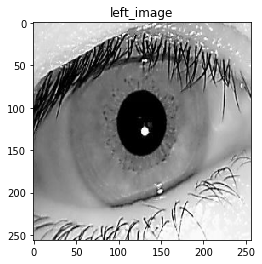

In [87]:
plt.title('left_image')
plt.imshow(image_R[1])
plt.show()

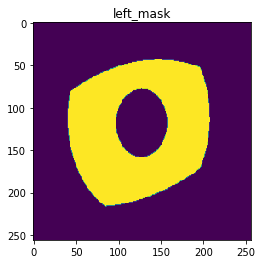

In [88]:
plt.title('left_mask')
plt.imshow(np.squeeze(mask_R[1]))
plt.show()

In [19]:
#pos_comb1 = np.array(list(combinations([1, 2, 3, 4, 5], 2)))
#pos_comb2 = np.array(list(combinations([6, 7, 8, 9, 10], 2)))

#neg_comb1 = np.array(list(product([2,3,4,5], [8,9,10])))
#print(neg_comb1)

In [89]:
folder_names = np.sort(os.listdir(path_input_images))

print(folder_names[0:20])

['001' '002' '003' '004' '005' '006' '007' '008' '009' '010' '011' '012'
 '013' '014' '015' '016' '017' '018' '019' '020']


In [90]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [91]:
initialize_weights = 'he_normal'
initialize_bias = 'he_normal'

In [92]:
def Saimese_Unet_model(input_shape):
    
    
    def unet_seg(X_input):
        n_filters=16
        dropout=.1
        batchnorm=True
        c1 = conv2d_block(X_input,n_filters*1,kernel_size=3,batchnorm=batchnorm)     
        p1 = MaxPooling2D((2,2))(c1)           # (h/2,w/2,16)
        p1 = Dropout(dropout)(p1) 

        c2 = conv2d_block(p1,n_filters*2,kernel_size=3,batchnorm=batchnorm)
        p2 = MaxPooling2D((2,2))(c2)  # (h/4,w/4,32)
        p2 = Dropout(dropout)(p2) 

        c3 = conv2d_block(p2,n_filters*4,kernel_size=3,batchnorm=batchnorm)
        p3 = MaxPooling2D((2,2))(c3)  # (h/8,w/8,64)
        p3 = Dropout(dropout)(p3) 

        c4 = conv2d_block(p3,n_filters*8,kernel_size=3,batchnorm=batchnorm)
        p4 = MaxPooling2D((2,2))(c4)  # (h/16,w/16,128)
        p4 = Dropout(dropout)(p4) 

        c5 = conv2d_block(p4,n_filters*16,kernel_size=3,batchnorm=batchnorm)      # (h/16,w/16,256)


        print("encoder done")


        u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)  # (h/8,w/8,128)
        u6 = concatenate([u6, c4])   # (h/8,w/8,128)
        u6 = Dropout(dropout)(u6)
        c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)     # (h/8,w/8,128)

        u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)  # (h/4,w/4,64)
        u7 = concatenate([u7, c3])   # (h/8,w/8,128)
        u7 = Dropout(dropout)(u7)
        c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)     # (h/4,w/4,64)

        u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)  # (h/2,w/2,32)
        u8 = concatenate([u8, c2])   # (h/2,w/2,32)
        u8 = Dropout(dropout)(u8)
        c8 = conv2d_block(u8, n_filters *2 , kernel_size = 3, batchnorm = batchnorm)     # (h/2,w/2,32)

        u9 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c8)  # (h,w,16)
        u9 = concatenate([u9, c1])   # (h,w,16)
        u9 = Dropout(dropout)(u9)
        c9 = conv2d_block(u9, n_filters, kernel_size = 3, batchnorm = batchnorm)     # (h,w,16)    


        print("decoder done")
        X_outputs = Conv2D(1,(1,1),activation='sigmoid')(c9)
        return X_outputs,c9
    
    
    
    
    def siamese_feature(Y_input):
        
        # Convolutional Neural Network        
        x = Conv2D(64, (10,10), activation='relu',
                       kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4))(Y_input)
        x1 = MaxPooling2D()(x)
        y = Conv2D(128, (7,7), activation='relu',
                         kernel_initializer=initialize_weights,
                         bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(x1)
        y1 = MaxPooling2D()(y)
        z = Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                         bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(y1)
        z1 = MaxPooling2D()(z)
        a = Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                         bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4))(z1)
        a1 = Flatten()(a)
        a2 = Dense(128, activation='sigmoid',
                       kernel_regularizer=l2(1e-3),
                       kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(a1)
        return a2

        # Generate the encodings (feature vectors) for the two images
    def siamese_match(Y_left_input,Y_right_input):
        
        #siamese_feature(Y_input)
        
        encoded_l = siamese_feature(Y_left_input)
        encoded_r = siamese_feature(Y_right_input)
        # Add a customized layer to compute the absolute difference between the encodings
        L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([encoded_l, encoded_r])

        # Add a dense layer with a sigmoid unit to generate the similarity score
        prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)  
        
        return prediction  
    
    
    
    
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
           
    left_seg,left_seg_c9 = unet_seg(left_input)
    
    right_seg,right_seg_c9 = unet_seg(right_input)
    
    prediction = siamese_match(left_seg_c9,right_seg_c9)

    model = Model(inputs=[left_input,right_input] ,outputs=[left_seg,right_seg,prediction],name='Saimese_Unet_model')
    
    return model

In [93]:
siamese_model = Saimese_Unet_model((256,256,3))

encoder done
decoder done
encoder done
decoder done


In [94]:
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [95]:
def custom_loss(y_true, y_pred):
 
    # calculating mean square error between target and predicted values 
    #mean_loss = K.mean(K.square(y_pred[:,0:12] - y_true[:,0:12]), axis=-1)   ## batchsize ,13
    #mnea_loss  = 
    
    
    cross_entropy_loss_seg_left = K.binary_crossentropy(y_true[0], y_pred[0], from_logits=False)
    cross_entropy_loss_seg_right = K.binary_crossentropy(y_true[1], y_pred[1], from_logits=False)
    
    ## calculate cross entrophy error for simaese 
    cross_entropy_loss_class = K.binary_crossentropy(y_true[3], y_pred[3], from_logits=False)
    
    ## only training for parametric loss  
   
    
    loss  = concatenate([cross_entropy_loss_seg_left,cross_entropy_loss_seg_right,cross_entropy_loss_class])
    # multiplying the values with weights along batch dimension
    #loss = loss * [.0001,.0001, 0.9999]          # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    
    loss = K.sum(loss)        # (batch_size,)
#     print('mean_square_loss  =', cross_entropy_loss_seg_left)
#     print('cross_entropy_loss  =', cross_entropy_loss_class)
    return loss

In [97]:
#optimizer = keras.optimizers.Adam(lr = 0.0001)


#siamese_model.compile(loss=custom_loss, optimizer=optimizer, metrics = ['mae', 'acc'])
siamese_model.compile(loss=custom_loss, optimizer='Adam', metrics = ['mae', 'acc'])

In [98]:
#steps_per_epoch = train_length // batch_size
batch_size = 1
steps_per_epoch = len(folder_name_list) // batch_size
validation_steps = len(folder_name_list_test) // batch_size

In [99]:

# history = siamese_model.fit_generator(imageLoader(path_input_images,folder_name_list,batch_size),steps_per_epoch,
#                     validation_data = imageLoader(path_input_images,folder_name_list_test,batch_size), 
#                     validation_steps=validation_steps, epochs=50)

In [100]:
history = siamese_model.fit_generator(imageLoader(path_input_images,folder_name_list,mask_path,batch_size),steps_per_epoch,
                    validation_data = imageLoader(path_input_images,folder_name_list_test,mask_path,batch_size), 
                    validation_steps=validation_steps, epochs=200)

Epoch 1/200
200/200 [==============================] - 111s 555ms/step - loss: 55999.5712 - conv2d_19_loss: 22801.6961 - conv2d_38_loss: 33195.2397 - dense_3_loss: 1.9182 - conv2d_19_mean_absolute_error: 0.0942 - conv2d_19_acc: 0.9645 - conv2d_38_mean_absolute_error: 0.2577 - conv2d_38_acc: 0.8013 - dense_3_mean_absolute_error: 0.5004 - dense_3_acc: 0.5000 - val_loss: 141910.8039 - val_conv2d_19_loss: 87945.1988 - val_conv2d_38_loss: 53963.2289 - val_dense_3_loss: 1.9095 - val_conv2d_19_mean_absolute_error: 0.1387 - val_conv2d_19_acc: 0.8785 - val_conv2d_38_mean_absolute_error: 0.1992 - val_conv2d_38_acc: 0.8346 - val_dense_3_mean_absolute_error: 0.5000 - val_dense_3_acc: 0.5000
Epoch 2/200
200/200 [==============================] - 95s 473ms/step - loss: 15491.1001 - conv2d_19_loss: 6469.3152 - conv2d_38_loss: 9019.5269 - dense_3_loss: 1.9096 - conv2d_19_mean_absolute_error: 0.0243 - conv2d_19_acc: 0.9828 - conv2d_38_mean_absolute_error: 0.1666 - conv2d_38_acc: 0.8143 - dense_3_mean_a

Epoch 13/200
200/200 [==============================] - 96s 478ms/step - loss: 3413.4751 - conv2d_19_loss: 1633.1602 - conv2d_38_loss: 1777.7906 - dense_3_loss: 1.9440 - conv2d_19_mean_absolute_error: 0.0045 - conv2d_19_acc: 0.9842 - conv2d_38_mean_absolute_error: 0.1249 - conv2d_38_acc: 0.9004 - dense_3_mean_absolute_error: 0.4992 - dense_3_acc: 0.5000 - val_loss: 161497.3969 - val_conv2d_19_loss: 118575.1121 - val_conv2d_38_loss: 42919.7828 - val_dense_3_loss: 1.9758 - val_conv2d_19_mean_absolute_error: 0.0922 - val_conv2d_19_acc: 0.8999 - val_conv2d_38_mean_absolute_error: 0.1646 - val_conv2d_38_acc: 0.8321 - val_dense_3_mean_absolute_error: 0.5053 - val_dense_3_acc: 0.5000
Epoch 14/200
200/200 [==============================] - 96s 478ms/step - loss: 7414.2605 - conv2d_19_loss: 5692.5629 - conv2d_38_loss: 1719.1591 - dense_3_loss: 1.9205 - conv2d_19_mean_absolute_error: 0.0148 - conv2d_19_acc: 0.9784 - conv2d_38_mean_absolute_error: 0.1225 - conv2d_38_acc: 0.9039 - dense_3_mean_abs

Epoch 25/200
200/200 [==============================] - 96s 479ms/step - loss: 4347.0115 - conv2d_19_loss: 1834.0623 - conv2d_38_loss: 2509.8752 - dense_3_loss: 0.9472 - conv2d_19_mean_absolute_error: 0.0036 - conv2d_19_acc: 0.9856 - conv2d_38_mean_absolute_error: 0.1069 - conv2d_38_acc: 0.8841 - dense_3_mean_absolute_error: 0.3756 - dense_3_acc: 0.7800 - val_loss: 176865.9492 - val_conv2d_19_loss: 131365.2773 - val_conv2d_38_loss: 45496.9459 - val_dense_3_loss: 1.6926 - val_conv2d_19_mean_absolute_error: 0.0925 - val_conv2d_19_acc: 0.8997 - val_conv2d_38_mean_absolute_error: 0.1148 - val_conv2d_38_acc: 0.8783 - val_dense_3_mean_absolute_error: 0.4974 - val_dense_3_acc: 0.5000
Epoch 26/200
200/200 [==============================] - 96s 479ms/step - loss: 3909.0338 - conv2d_19_loss: 1796.9352 - conv2d_38_loss: 2108.6067 - dense_3_loss: 1.4603 - conv2d_19_mean_absolute_error: 0.0036 - conv2d_19_acc: 0.9855 - conv2d_38_mean_absolute_error: 0.1073 - conv2d_38_acc: 0.8831 - dense_3_mean_abs

Epoch 37/200
200/200 [==============================] - 96s 479ms/step - loss: 3176.1351 - conv2d_19_loss: 1617.5253 - conv2d_38_loss: 1556.1434 - dense_3_loss: 0.8919 - conv2d_19_mean_absolute_error: 0.0026 - conv2d_19_acc: 0.9857 - conv2d_38_mean_absolute_error: 0.1125 - conv2d_38_acc: 0.8764 - dense_3_mean_absolute_error: 0.2743 - dense_3_acc: 0.8962 - val_loss: 217448.4727 - val_conv2d_19_loss: 131461.3992 - val_conv2d_38_loss: 85983.5570 - val_dense_3_loss: 1.9587 - val_conv2d_19_mean_absolute_error: 0.0866 - val_conv2d_19_acc: 0.9056 - val_conv2d_38_mean_absolute_error: 0.1245 - val_conv2d_38_acc: 0.8683 - val_dense_3_mean_absolute_error: 0.5452 - val_dense_3_acc: 0.3750
Epoch 38/200
200/200 [==============================] - 96s 479ms/step - loss: 3116.4131 - conv2d_19_loss: 1584.1756 - conv2d_38_loss: 1529.7754 - dense_3_loss: 0.9231 - conv2d_19_mean_absolute_error: 0.0025 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.1128 - conv2d_38_acc: 0.8760 - dense_3_mean_abs

Epoch 49/200
200/200 [==============================] - 96s 480ms/step - loss: 2848.2869 - conv2d_19_loss: 1395.9038 - conv2d_38_loss: 1449.8945 - dense_3_loss: 0.8329 - conv2d_19_mean_absolute_error: 0.0014 - conv2d_19_acc: 0.9859 - conv2d_38_mean_absolute_error: 0.1071 - conv2d_38_acc: 0.8815 - dense_3_mean_absolute_error: 0.3093 - dense_3_acc: 0.9087 - val_loss: 256481.8164 - val_conv2d_19_loss: 165164.0695 - val_conv2d_38_loss: 91314.5437 - val_dense_3_loss: 1.5856 - val_conv2d_19_mean_absolute_error: 0.0876 - val_conv2d_19_acc: 0.9042 - val_conv2d_38_mean_absolute_error: 0.1176 - val_conv2d_38_acc: 0.8749 - val_dense_3_mean_absolute_error: 0.4703 - val_dense_3_acc: 0.5000
Epoch 50/200
200/200 [==============================] - 96s 479ms/step - loss: 2864.4155 - conv2d_19_loss: 1411.1192 - conv2d_38_loss: 1450.7222 - dense_3_loss: 0.9554 - conv2d_19_mean_absolute_error: 0.0016 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.1071 - conv2d_38_acc: 0.8815 - dense_3_mean_abs

Epoch 61/200
200/200 [==============================] - 97s 484ms/step - loss: 3121.3071 - conv2d_19_loss: 1397.0203 - conv2d_38_loss: 1721.5636 - dense_3_loss: 1.5707 - conv2d_19_mean_absolute_error: 0.0014 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0899 - conv2d_38_acc: 0.8995 - dense_3_mean_absolute_error: 0.4379 - dense_3_acc: 0.5825 - val_loss: 228622.4422 - val_conv2d_19_loss: 172099.5250 - val_conv2d_38_loss: 56520.0623 - val_dense_3_loss: 1.7285 - val_conv2d_19_mean_absolute_error: 0.0936 - val_conv2d_19_acc: 0.8982 - val_conv2d_38_mean_absolute_error: 0.1118 - val_conv2d_38_acc: 0.8810 - val_dense_3_mean_absolute_error: 0.4623 - val_dense_3_acc: 0.5000
Epoch 62/200
200/200 [==============================] - 96s 482ms/step - loss: 2902.1192 - conv2d_19_loss: 1354.6984 - conv2d_38_loss: 1544.8544 - dense_3_loss: 1.4543 - conv2d_19_mean_absolute_error: 0.0012 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0904 - conv2d_38_acc: 0.8984 - dense_3_mean_abs

Epoch 73/200
200/200 [==============================] - 96s 480ms/step - loss: 2726.5947 - conv2d_19_loss: 1338.4278 - conv2d_38_loss: 1385.5408 - dense_3_loss: 1.7930 - conv2d_19_mean_absolute_error: 0.0011 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0897 - conv2d_38_acc: 0.8986 - dense_3_mean_absolute_error: 0.4814 - dense_3_acc: 0.5000 - val_loss: 224362.2477 - val_conv2d_19_loss: 155900.5914 - val_conv2d_38_loss: 68458.9283 - val_dense_3_loss: 1.9354 - val_conv2d_19_mean_absolute_error: 0.0776 - val_conv2d_19_acc: 0.9144 - val_conv2d_38_mean_absolute_error: 0.1052 - val_conv2d_38_acc: 0.8870 - val_dense_3_mean_absolute_error: 0.4915 - val_dense_3_acc: 0.5000
Epoch 74/200
200/200 [==============================] - 96s 480ms/step - loss: 2718.0913 - conv2d_19_loss: 1334.3965 - conv2d_38_loss: 1381.1436 - dense_3_loss: 1.7552 - conv2d_19_mean_absolute_error: 0.0011 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0906 - conv2d_38_acc: 0.8976 - dense_3_mean_abs

Epoch 85/200
200/200 [==============================] - 96s 480ms/step - loss: 2730.8732 - conv2d_19_loss: 1317.3983 - conv2d_38_loss: 1411.2510 - dense_3_loss: 1.6217 - conv2d_19_mean_absolute_error: 9.2768e-04 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0864 - conv2d_38_acc: 0.9019 - dense_3_mean_absolute_error: 0.4475 - dense_3_acc: 0.5012 - val_loss: 266755.1781 - val_conv2d_19_loss: 192661.5367 - val_conv2d_38_loss: 74091.1277 - val_dense_3_loss: 1.9462 - val_conv2d_19_mean_absolute_error: 0.0868 - val_conv2d_19_acc: 0.9052 - val_conv2d_38_mean_absolute_error: 0.1133 - val_conv2d_38_acc: 0.8788 - val_dense_3_mean_absolute_error: 0.4447 - val_dense_3_acc: 0.6500
Epoch 86/200
200/200 [==============================] - 96s 480ms/step - loss: 2722.5888 - conv2d_19_loss: 1318.6147 - conv2d_38_loss: 1401.7771 - dense_3_loss: 1.6161 - conv2d_19_mean_absolute_error: 9.0253e-04 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0862 - conv2d_38_acc: 0.9019 - dense_3_

Epoch 97/200
200/200 [==============================] - 96s 479ms/step - loss: 2697.0709 - conv2d_19_loss: 1325.6862 - conv2d_38_loss: 1368.9395 - dense_3_loss: 1.9346 - conv2d_19_mean_absolute_error: 9.2438e-04 - conv2d_19_acc: 0.9859 - conv2d_38_mean_absolute_error: 0.0873 - conv2d_38_acc: 0.9008 - dense_3_mean_absolute_error: 0.4997 - dense_3_acc: 0.5012 - val_loss: 360677.8594 - val_conv2d_19_loss: 285684.6430 - val_conv2d_38_loss: 74990.8461 - val_dense_3_loss: 1.9109 - val_conv2d_19_mean_absolute_error: 0.1160 - val_conv2d_19_acc: 0.8763 - val_conv2d_38_mean_absolute_error: 0.1135 - val_conv2d_38_acc: 0.8786 - val_dense_3_mean_absolute_error: 0.5000 - val_dense_3_acc: 0.5000
Epoch 98/200
200/200 [==============================] - 96s 479ms/step - loss: 2689.3111 - conv2d_19_loss: 1323.7410 - conv2d_38_loss: 1363.1680 - dense_3_loss: 1.9102 - conv2d_19_mean_absolute_error: 0.0010 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0877 - conv2d_38_acc: 0.9003 - dense_3_mean

Epoch 109/200
200/200 [==============================] - 96s 480ms/step - loss: 2674.2323 - conv2d_19_loss: 1309.0329 - conv2d_38_loss: 1363.9585 - dense_3_loss: 0.7727 - conv2d_19_mean_absolute_error: 8.1981e-04 - conv2d_19_acc: 0.9859 - conv2d_38_mean_absolute_error: 0.0862 - conv2d_38_acc: 0.9019 - dense_3_mean_absolute_error: 0.3377 - dense_3_acc: 0.8200 - val_loss: 387459.6500 - val_conv2d_19_loss: 286321.9656 - val_conv2d_38_loss: 101135.7410 - val_dense_3_loss: 1.4810 - val_conv2d_19_mean_absolute_error: 0.1165 - val_conv2d_19_acc: 0.8757 - val_conv2d_38_mean_absolute_error: 0.1137 - val_conv2d_38_acc: 0.8783 - val_dense_3_mean_absolute_error: 0.4658 - val_dense_3_acc: 0.5875
Epoch 110/200
200/200 [==============================] - 96s 480ms/step - loss: 2670.3573 - conv2d_19_loss: 1307.0118 - conv2d_38_loss: 1362.1506 - dense_3_loss: 0.7149 - conv2d_19_mean_absolute_error: 7.6370e-04 - conv2d_19_acc: 0.9859 - conv2d_38_mean_absolute_error: 0.0852 - conv2d_38_acc: 0.9029 - dense

Epoch 121/200
200/200 [==============================] - 102s 510ms/step - loss: 2666.0356 - conv2d_19_loss: 1315.0053 - conv2d_38_loss: 1348.6834 - dense_3_loss: 1.8930 - conv2d_19_mean_absolute_error: 8.9657e-04 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0878 - conv2d_38_acc: 0.9003 - dense_3_mean_absolute_error: 0.4978 - dense_3_acc: 0.5000 - val_loss: 303263.3617 - val_conv2d_19_loss: 208837.1633 - val_conv2d_38_loss: 94424.4762 - val_dense_3_loss: 1.2948 - val_conv2d_19_mean_absolute_error: 0.1029 - val_conv2d_19_acc: 0.8891 - val_conv2d_38_mean_absolute_error: 0.1119 - val_conv2d_38_acc: 0.8803 - val_dense_3_mean_absolute_error: 0.4431 - val_dense_3_acc: 0.5000
Epoch 122/200
200/200 [==============================] - 99s 493ms/step - loss: 2661.5826 - conv2d_19_loss: 1311.1483 - conv2d_38_loss: 1348.0926 - dense_3_loss: 1.8677 - conv2d_19_mean_absolute_error: 8.9144e-04 - conv2d_19_acc: 0.9858 - conv2d_38_mean_absolute_error: 0.0872 - conv2d_38_acc: 0.9008 - dense

KeyboardInterrupt: 

In [101]:
import matplotlib.pyplot as plt
# Let's take a look at how we did during training.
acc = history.history['conv2d_38_acc']
val_acc = history.history['val_conv2d_38_acc']

loss = history.history['conv2d_38_loss']
val_loss = history.history['val_conv2d_38_loss']
epochs = range(len(acc))

# Accuracy
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

# Loss
ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

plt.show()

NameError: name 'history' is not defined

In [102]:
model_save_path = '/tensorflow/samese_model/siamese_unet_pixel_seg_200epoch_test.h5'

siamese_model.save(model_save_path)

In [106]:
siamese_model = load_model(model_save_path,custom_objects={'custom_loss': custom_loss})

In [128]:
Out = next((imageLoader(path_input_images,folder_name_list_test,mask_path,1)))

In [129]:
images_L_R = Out[0]
image_L = images_L_R[0]
image_R = images_L_R[1]

mask_L_R_class = Out[1]

mask_L = mask_L_R_class[0]
mask_R = mask_L_R_class[1]
y = mask_L_R_class[2]
print(y[0])
print(image_L.shape)
#plt.title('left_mask')
#plt.imshow(np.squeeze(mask_R[1]))
#plt.imshow(image_R[1])
#plt.show()

0.0
(4, 256, 256, 3)


In [130]:




preds = siamese_model.predict([image_L,image_R])





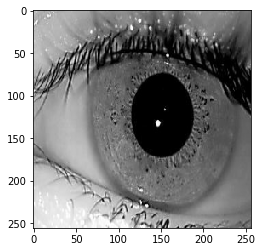

In [139]:

#plt.imshow(np.squeeze(mask_R[1]))
plt.imshow(image_R[1])
plt.show()

In [140]:
out_image = np.squeeze(preds[1][1])
preds[0].shape

(4, 256, 256, 1)

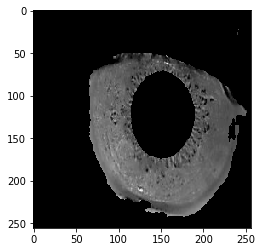

In [141]:

dummy_image = image_R[1].copy() 
dummy_image[out_image<.5] = 0
plt.imshow(dummy_image)
plt.show()